# Projet : Autoguidage (Self-Guidance) pour les Modèles de Diffusion

Ce notebook explore la méthode de l'**Autoguidage** (Self-Guidance), une technique innovante introduite par NVIDIA en 2024 pour améliorer la qualité des images générées.

---

## 1) Exemple Visuel : L'intuition sur un Toy Example (S-Curve)

Avant de passer à des images complexes (MNIST), nous allons illustrer le principe sur des données simplifiées en 2D. L'objectif ici est de comprendre comment un modèle de diffusion apprend à "sculpter" une distribution de données à partir d'un bruit total.

Nous commençons par définir notre **Ground Truth** (la vérité terrain). Ici, nos données forment un "S". C'est cette forme que nos modèles devront apprendre à reconstruire.

Text(0.5, 1.0, 'Vraies données (Ground Truth)')

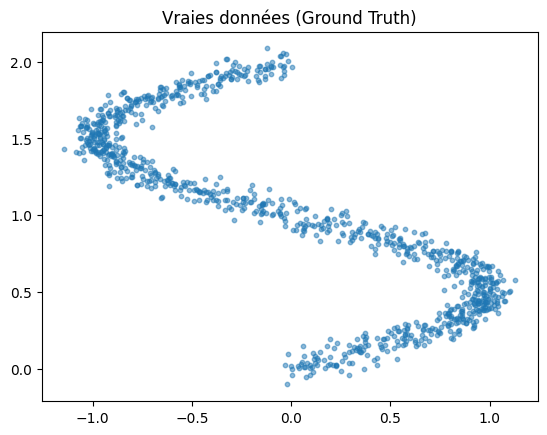

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_data(n=1000):
    t = np.linspace(0, 1, n)
    x = np.sin(2 * np.pi * t) + np.random.normal(0, 0.05, n)
    y = t * 2 + np.random.normal(0, 0.05, n)
    return np.stack([x, y], axis=1)

data = get_data()
plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.5)
plt.title("Vraies données (Ground Truth)")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_s_curve(n=2000):
    t = torch.linspace(0, 1, n)
    x = 1.5 * torch.sin(2 * np.pi * t)
    y = t * 4 - 2
    data = torch.stack([x, y], dim=1)
    return data + torch.randn_like(data) * 0.1

data = generate_s_curve().to(device)


Pour ce problème en 2D, nous utilisons un réseau de neurones simple (Multi-Layer Perceptron).
Le modèle prend en entrée :
* Les coordonnées $(x, y)$ d'un point bruité.
* Le temps $t$ (le niveau de bruit).

Il doit prédire le **score** (le gradient de la densité), qui indique la direction vers laquelle déplacer le point pour revenir vers la structure en "S".

In [3]:
class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128), # x, y, et t
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x, t):
        # x a une forme [N, 2]
        # t est un scalaire

        # On crée un tenseur de t qui a la même première dimension que x
        if t.dim() == 0 or (t.dim() == 1 and t.shape[0] == 1):
            t_input = t.expand(x.shape[0], 1)
        else:
            t_input = t.view(-1, 1)

        # Maintenant on peut les concaténer
        inputs = torch.cat([x, t_input], dim=1)
        return self.net(inputs)

C'est ici que la logique de l'article de NVIDIA intervient. Nous entraînons deux versions du même modèle :

1.  **L'Expert ($D_1$)** : Entraîné longuement (5000 époques). Il connaît parfaitement la structure fine du "S".
2.  **L'Amateur ($D_0$)** : Entraîné très peu de temps (500 époques). Il a une idée vague de la forme mais ses prédictions sont imprécises.

**L'idée de l'Autoguidage :** En soustrayant les erreurs de l'amateur à celles de l'expert, nous allons "nettoyer" le signal de génération.

In [4]:
def train(model, data, epochs=5000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        # 1. Choisir un temps t aléatoire
        t = torch.rand(1).to(device)

        # 2. Ajouter du bruit selon t
        noise = torch.randn_like(data)
        std = t # Plus t est grand, plus on est bruité
        noisy_data = data + noise * std

        # 3. Prédire le bruit
        pred_noise = model(noisy_data, t)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Entraînement de l'EXPERT (D1) et de l'AMATEUR (D0)
print("Entraînement de l'Expert (D1)...")
D1 = ScoreNet().to(device)
train(D1, data, epochs=5000)

print("Entraînement de l'Amateur (D0 - Moins de neurones et d'étapes)...")
D0 = ScoreNet().to(device)
train(D0, data, epochs=1000)

Entraînement de l'Expert (D1)...
Epoch 0, Loss: 1.0413
Epoch 1000, Loss: 0.4664
Epoch 2000, Loss: 0.4363
Epoch 3000, Loss: 0.4125
Epoch 4000, Loss: 0.4797
Entraînement de l'Amateur (D0 - Moins de neurones et d'étapes)...
Epoch 0, Loss: 1.0175


Nous utilisons un processus de débruitage itératif. À chaque pas, nous calculons le score guidé :
$$Score_{guidé} = Score_{Amateur} + w \cdot (Score_{Expert} - Score_{Amateur})$$

Le paramètre $w$ (weight) contrôle la force du guidage.
* Si $w=0$ : On utilise l'expert pur.
* Si $w > 0$ : On amplifie les détails fins que seul l'expert maîtrise par rapport à l'amateur.

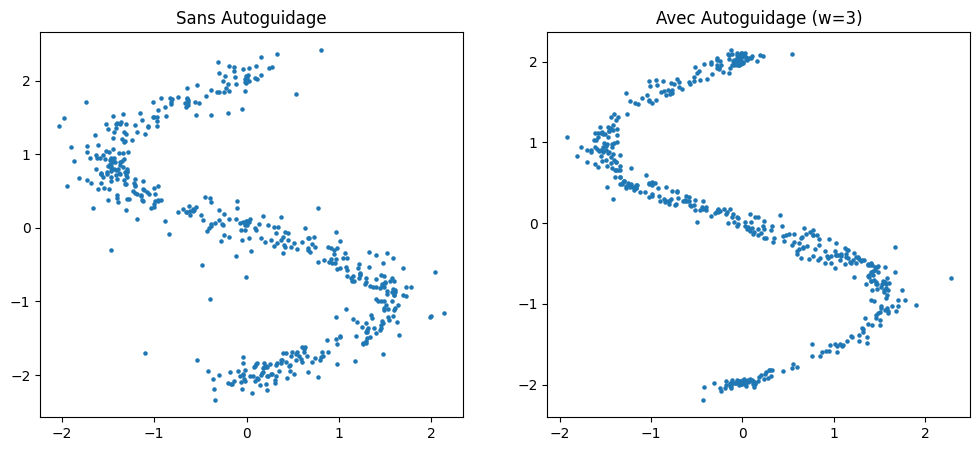

In [5]:
def sample(model_expert, model_guide=None, w=0.0, steps=100):
    model_expert.eval()
    if model_guide: model_guide.eval()

    # 1. Partir du bruit pur
    x = torch.randn(500, 2).to(device) * 2

    # 2. Remonter le temps de t=1 à t=0
    dt = 1.0 / steps
    for i in range(steps):
        t = torch.tensor([1.0 - i*dt]).to(device)

        with torch.no_grad():
            v_eps = model_expert(x, t)
            if model_guide is not None and w > 0:
                v_bad = model_guide(x, t)
                # FORMULE DE L'ARTICLE :
                v_eps = v_bad + w * (v_eps - v_bad)

            # On retire un peu de bruit à chaque pas
            x = x - v_eps * dt

    return x.cpu().numpy()

# Comparaison visuelle
pts_no_guidance = sample(D1, w=0.0)
pts_with_autoguidance = sample(D1, D0, w=3.0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.scatter(pts_no_guidance[:,0], pts_no_guidance[:,1], s=5); plt.title("Sans Autoguidage")
plt.subplot(1, 2, 2); plt.scatter(pts_with_autoguidance[:,0], pts_with_autoguidance[:,1], s=5); plt.title("Avec Autoguidage (w=3)")
plt.show()

Pour bien comprendre ce qui se passe, nous affichons les champs de vecteurs (gradients).
* **Vert** : Où l'expert veut emmener les points.
* **Rouge** : Où l'amateur (imprécis) veut les emmener.
* **Bleu** : Le résultat de l'autoguidage qui affine la direction finale.

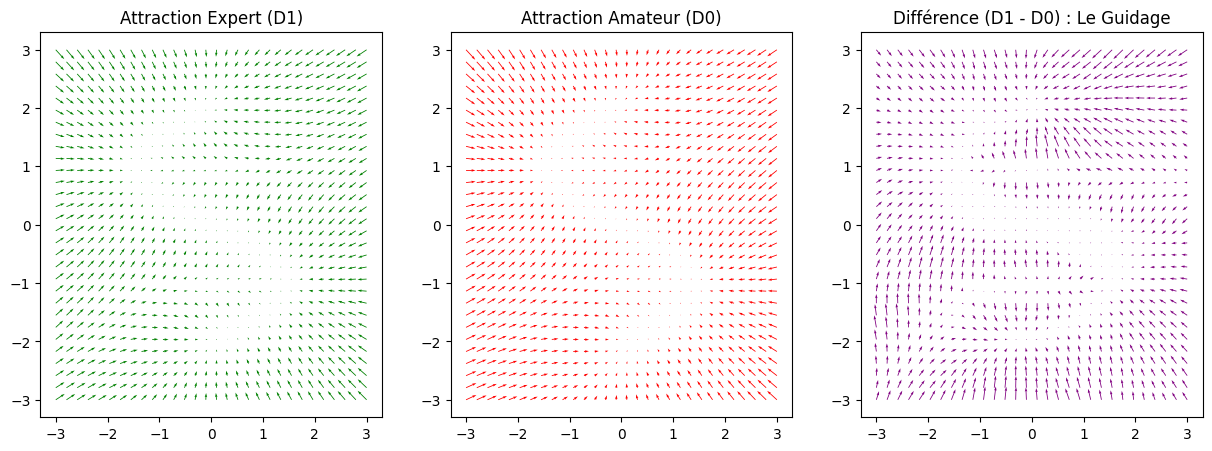

In [6]:
def plot_guidance(D1, D0, w=2.0):
    x_range = torch.linspace(-3, 3, 30)
    y_range = torch.linspace(-3, 3, 30)
    grid_x, grid_y = torch.meshgrid(x_range, y_range, indexing='ij')
    coords = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1).to(device)

    t = torch.tensor([0.2]).to(device) # On regarde à un niveau de bruit moyen

    # Calcul de la différence (la direction du guidage pur)
    with torch.no_grad():
        v1 = D1(coords, t)
        v0 = D0(coords, t)
        v_diff = v1 - v0

    plt.figure(figsize=(15, 5))

    # 1. L'Expert
    plt.subplot(1, 3, 1)
    plt.quiver(coords[:,0].cpu(), coords[:,1].cpu(), -v1[:,0].cpu(), -v1[:,1].cpu(), color='green')
    plt.title("Attraction Expert (D1)")

    # 2. L'Amateur
    plt.subplot(1, 3, 2)
    plt.quiver(coords[:,0].cpu(), coords[:,1].cpu(), -v0[:,0].cpu(), -v0[:,1].cpu(), color='red')
    plt.title("Attraction Amateur (D0)")

    # 3. La Différence
    plt.subplot(1, 3, 3)
    plt.quiver(coords[:,0].cpu(), coords[:,1].cpu(), -v_diff[:,0].cpu(), -v_diff[:,1].cpu(), color='purple')
    plt.title("Différence (D1 - D0) : Le Guidage")

    plt.show()

plot_guidance(D1, D0)


---


## 2) Application sur les données MNIST

Maintenant que nous avons validé l'intuition sur des données 2D, nous passons à la génération d'images réelles en utilisant le dataset **MNIST**.

### Objectifs de cette section :
1.  **Conditionnement** : Apprendre au modèle à générer un chiffre spécifique à partir d'un "prompt" (label).
2.  **Guidage Comparatif** : Comparer visuellement l'**Autoguidage** de NVIDIA avec la méthode standard **Classifier-Free Guidance (CFG)**.
3.  **Qualité** : Observer comment l'autoguidage affine les détails des chiffres sans saturer l'image.

In [7]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from scipy import integrate
import matplotlib.colors as colors
from torch.optim import Adam
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Nous définissons ici les deux fonctions qui dictent la dynamique du bruit dans notre modèle :

1.  **`marginal_prob_std`** : Calcule l'écart-type $\sigma(t)$ du bruit à un instant donné. Elle permet de savoir à quel point l'image est "effacée" par le bruit au cours du temps.
2.  **`diffusion_coeff`** : Définit la vitesse de propagation du bruit. C'est ce coefficient qui guide l'algorithme d'échantillonnage pour reconstruire l'image étape par étape.

In [9]:
def marginal_prob_std(t, sigma):
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  return torch.tensor(sigma**t, device=device)

Nous téléchargeons et préparons les images de chiffres manuscrits.

In [10]:
batch_size =  64 #@param {'type':'integer'}
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
data_iter = iter(data_loader)

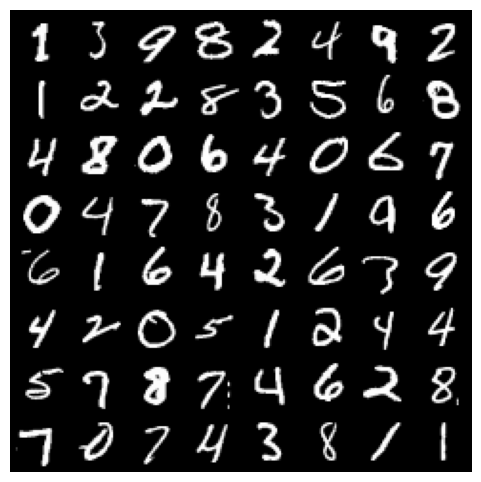

In [11]:
samples, _ = next(data_iter)
sample_grid = make_grid(samples)
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [12]:
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

Les modèles de diffusion ont besoin de connaître précisément l'instant $t$ pour adapter leur force de débruitage. Cependant, une simple valeur numérique est difficile à traiter pour un réseau de neurones.

Nous utilisons ici des **Projections de Fourier Gaussiennes** pour transformer le temps en un vecteur de haute dimension. Cette technique permet au modèle de capturer des variations très fines dans les échelles de bruit, un peu comme le *Positional Encoding* dans les Transformers.

In [13]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

Nous définissons ici le cœur de notre système. Ce modèle est un **U-Net** capable de traiter des images tout en étant guidé par deux informations externes :
1.  **Le Temps ($t$)** : Indique au modèle le niveau de bruit actuel.
2.  **Le Label ($y$)** : Permet de choisir le chiffre à générer (le "prompt").

La classe `Dense` permet de transformer ces informations (temps et labels) en formats compatibles avec les images, afin qu'elles puissent être fusionnées au sein des couches de convolution. Grâce à cette structure, le réseau apprend à "sculpter" le bruit pour faire apparaître le chiffre demandé.

In [14]:
class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ConditionalScoreNet(nn.Module):
  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256, num_classes=11):
    super().__init__()

    # Embedding du temps (existant)
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))

    # NOUVEAU : Embedding des labels (0-9 + 1 pour le label vide/uncond)
    self.label_embed = nn.Sequential(
        nn.Embedding(num_classes, embed_dim),
        nn.Linear(embed_dim, embed_dim)
    )

    # Encoding layers
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.ldense1 = Dense(embed_dim, channels[0]) # Projection label
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.ldense2 = Dense(embed_dim, channels[1]) # Projection label
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.ldense3 = Dense(embed_dim, channels[2]) # Projection label
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.ldense4 = Dense(embed_dim, channels[3]) # Projection label
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.ldense5 = Dense(embed_dim, channels[2]) # Projection label
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.ldense6 = Dense(embed_dim, channels[1]) # Projection label
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.ldense7 = Dense(embed_dim, channels[0]) # Projection label
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t, y):
    # Encodage du temps et du label
    embed = self.act(self.embed(t))
    l_embed = self.act(self.label_embed(y))

    # Encoding path
    h1 = self.conv1(x)
    h1 += self.dense1(embed) + self.ldense1(l_embed) # Fusion t et y
    h1 = self.act(self.gnorm1(h1))

    h2 = self.conv2(h1)
    h2 += self.dense2(embed) + self.ldense2(l_embed)
    h2 = self.act(self.gnorm2(h2))

    h3 = self.conv3(h2)
    h3 += self.dense3(embed) + self.ldense3(l_embed)
    h3 = self.act(self.gnorm3(h3))

    h4 = self.conv4(h3)
    h4 += self.dense4(embed) + self.ldense4(l_embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path
    h = self.tconv4(h4)
    h += self.dense5(embed) + self.ldense5(l_embed)
    h = self.act(self.tgnorm4(h))

    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed) + self.ldense6(l_embed)
    h = self.act(self.tgnorm3(h))

    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed) + self.ldense7(l_embed)
    h = self.act(self.tgnorm2(h))

    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalisation finale par sigma(t)
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [15]:
# Initialisation de l'Expert
expert = ConditionalScoreNet(marginal_prob_std=marginal_prob_std_fn, num_classes=11)
expert = torch.nn.DataParallel(expert).to(device)

# Initialisation de l'Amateur
# Même architecture, mais on l'entraînera moins (plus simple)
amateur = ConditionalScoreNet(marginal_prob_std=marginal_prob_std_fn, num_classes=11)
amateur = torch.nn.DataParallel(amateur).to(device)

Nous utilisons l'algorithme d'**Euler-Maruyama** pour transformer un bloc de bruit blanc en un chiffre lisible. Le processus de diffusion inversée est guidé par nos deux modèles.

* **Mode CFG** : Utilise uniquement l'expert. Il compare `Expert(Label)` et `Expert(Vide)`.
* **Mode Autoguidage** : Utilise les deux modèles. Il compare `Expert(Label)` et `Amateur(Label)`.

In [16]:
## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Autoguidance_Euler_Maruyama_sampler(expert_model,
                                       amateur_model,
                                       marginal_prob_std,
                                       diffusion_coeff,
                                       prompt_label,   # Le chiffre à générer (0-9)
                                       batch_size=64,
                                       num_steps=500,
                                       device='cuda',
                                       w=2.0,           # Poids de l'autoguidage
                                       eps=1e-3):

  t = torch.ones(batch_size, device=device)
  # Initialisation avec du bruit blanc mis à l'échelle
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]

  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x

  # Préparation du vecteur de labels pour le conditionnement
  # On crée un tenseur rempli du chiffre demandé (ex: tous des "5")
  labels = torch.ones(batch_size, dtype=torch.long, device=device) * prompt_label

  with torch.no_grad():
    for time_step in tqdm(time_steps, desc="Sampling"):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)

      # --- CALCUL DU SCORE GUIDÉ ---
      # 1. On demande à l'expert de prédire le score pour le label 'y'
      score_expert = expert_model(x, batch_time_step, labels)

      # 2. On demande à l'amateur (bad version) de faire de même
      score_amateur = amateur_model(x, batch_time_step, labels)

      # 3. Formule d'autoguidage : amplifie la différence Expert/Amateur
      # Cette soustraction élimine les erreurs communes et affine les détails
      guided_score = score_amateur + w * (score_expert - score_amateur)
      # -----------------------------

      # Mise à jour de l'échantillon (Equation de Langevin / Euler-Maruyama)
      mean_x = x + (g**2)[:, None, None, None] * guided_score * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

  # On retourne la moyenne finale (image débruitée)
  return mean_x

def CFG_Euler_Maruyama_sampler(model,
                               marginal_prob_std,
                               diffusion_coeff,
                               prompt_label,
                               batch_size=64,
                               num_steps=500,
                               device='cuda',
                               w=3.0, # Force du CFG
                               eps=1e-3):

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x

  # On prépare les deux types de labels
  labels_cond = torch.ones(batch_size, dtype=torch.long, device=device) * prompt_label
  labels_uncond = torch.ones(batch_size, dtype=torch.long, device=device) * 10 # Label "vide"

  with torch.no_grad():
    for time_step in tqdm(time_steps, desc="CFG Sampling"):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)

      # --- LOGIQUE CFG ---
      score_cond = model(x, batch_time_step, labels_cond)
      score_uncond = model(x, batch_time_step, labels_uncond)

      # Formule CFG : Score_uncond + w * (Score_cond - Score_uncond)
      guided_score = score_uncond + w * (score_cond - score_uncond)

      mean_x = x + (g**2)[:, None, None, None] * guided_score * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

  return mean_x

Le modèle ne prédit pas directement l'image, mais le **bruit** qui a été ajouté. La fonction de perte calcule l'écart entre le bruit réel $z$ injecté dans l'image et le score prédit par le réseau.

$$\mathcal{L} = \| \text{Score}_{prédit}(x_t, t, y) - \text{Bruit}_{réel} \|^2$$

Pendant l'entraînement, nous appliquons le **dropout de label** à hauteur de 10% sur l'Expert pour garantir la compatibilité avec le guidage CFG.

In [17]:
def loss_fn(model, x, labels, marginal_prob_std, eps=1e-5):
  """Fonction de perte pour l'entraînement conditionnel.

  Args:
    model: Ton ConditionalScoreNet.
    x: Images originales [batch, 1, 28, 28].
    labels: Chiffres réels (0-9) [batch].
    marginal_prob_std: Fonction sigma(t).
  """
  # 1. Échantillonnage du temps t et du bruit z
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)

  # 2. Perturbation de l'image (Forward process)
  perturbed_x = x + z * std[:, None, None, None]

  # 3. LABEL DROPOUT (Préparation pour le CFG)
  # On clone les labels pour ne pas modifier le dataset original
  y_input = labels.clone()
  # 10% de probabilité de remplacer le label par '10' (inconditionnel)
  mask = torch.rand(labels.shape[0], device=x.device) < 0.1
  y_input[mask] = 10

  # 4. Prédiction du score par le modèle
  # On passe perturbed_x, random_t ET les labels (parfois masqués)
  score = model(perturbed_x, random_t, y_input)

  # 5. Calcul de la perte (Score Matching objectif)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

### Entrainement
(L'entrainement prend environ 10min, des modèles déjà entrainés sont joints aux notebook et peuvent être chargés grace à la cellule en dessous)

Pour que l'autoguidage fonctionne, nous créons un déséquilibre de compétence :

* **L'Expert** : Possède beaucoup de canaux (puissance de calcul) et s'entraîne sur 15-20 époques. Il maîtrise la texture et les bords nets.
* **L'Amateur** : Possède 4x moins de canaux et s'arrête après seulement 2 époques. Il a une vision "floue" et simpliste du chiffre.

C'est en soustrayant cette vision "floue" de la vision "nette" que nous obtiendrons un résultat supérieur.

In [18]:
n_epochs = 30
amateur_epoch = 20  # L'époque où l'expert devient "l'amateur" officiel
tqdm_epoch = trange(n_epochs)

optimizer = Adam(expert.parameters(), lr=1e-4)

for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    expert.train() # Mode entraînement
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)

        # On entraîne uniquement l'expert
        loss = loss_fn(expert, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # --- LOGIQUE DE CAPTURE ---
    # Si on arrive à l'époque cible pour l'amateur
    if (epoch + 1) == amateur_epoch:
        # On copie l'état actuel de l'expert dans l'amateur
        amateur.load_state_dict(expert.state_dict())
        torch.save(amateur.state_dict(), 'amateur_ckpt.pth')
        print(f" -> Amateur figé à l'époque {epoch + 1}")

    # Mise à jour de l'affichage
    tqdm_epoch.set_description(f'Epoch {epoch+1} | Loss: {avg_loss / num_items:.4f}')

    # Sauvegarde de l'expert (qui continue de s'améliorer)
    torch.save(expert.state_dict(), 'expert_ckpt.pth')

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipython-input-3978179467.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


 -> Amateur figé à l'époque 20


Pour utiliser les modèles entraînés sans avoir à relancer tout le processus d'apprentissage (qui peut prendre une dizaine de minutes), vous pouvez exécuter la cellule ci-dessous.

In [19]:
# 1. Charger les fichiers bruts (SANS les nettoyer cette fois)
expert_state_dict = torch.load('expert_ckpt.pth', map_location=device)
amateur_state_dict = torch.load('amateur_ckpt.pth', map_location=device)

# 2. Charger directement (si tes modèles sont des DataParallel, ils trouveront les clés 'module.')
# Si tes fichiers n'ont pas de 'module.', PyTorch les chargera normalement si le modèle n'est pas DP.
expert.load_state_dict(expert_state_dict)
amateur.load_state_dict(amateur_state_dict)

# 3. Mode évaluation
expert.eval()
amateur.eval()

DataParallel(
  (module): ConditionalScoreNet(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (label_embed): Sequential(
      (0): Embedding(11, 256)
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (dense1): Dense(
      (dense): Linear(in_features=256, out_features=32, bias=True)
    )
    (ldense1): Dense(
      (dense): Linear(in_features=256, out_features=32, bias=True)
    )
    (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense2): Dense(
      (dense): Linear(in_features=256, out_features=64, bias=True)
    )
    (ldense2): Dense(
      (dense): Linear(in_features=256, out_features=64, bias=True)
    )
    (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), s

Nous utilisons notre échantillonneur d'**Autoguidage** pour transformer un bruit aléatoire en images structurées.

À l'aide des paramètres (widgets), vous pouvez choisir :
* **`prompt_label`** : Le chiffre spécifique que vous souhaitez générer.
* **`w_guidance`** : La force de l'autoguidage. Plus elle est élevée, plus le modèle expert corrigera les imprécisions de l'amateur pour produire un résultat net.

La grille de résultats permet d'observer la diversité des échantillons générés.

/tmp/ipython-input-3978179467.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Sampling:   0%|          | 0/800 [00:00<?, ?it/s]

/tmp/ipython-input-3978179467.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


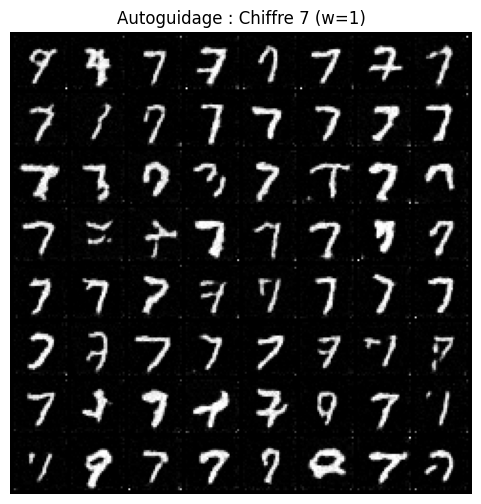

In [33]:
sample_batch_size = 64 #@param {'type':'integer'}
num_steps = 800 #@param {'type':'integer'}
w_guidance = 1 #@param {'type':'number'}
prompt_label = 7 #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] {'type':'raw'}

# Appel de la fonction avec l'argument prompt_label ajouté
samples = Autoguidance_Euler_Maruyama_sampler(expert,
                                              amateur,
                                              marginal_prob_std_fn,
                                              diffusion_coeff_fn,
                                              prompt_label=prompt_label, # <--- AJOUTÉ
                                              batch_size=sample_batch_size,
                                              num_steps=num_steps,
                                              device=device,
                                              w=w_guidance)

## Visualisation
samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.title(f"Autoguidage : Chiffre {prompt_label} (w={w_guidance})")
plt.show()

Nous générons maintenant les mêmes chiffres (même seed) avec les trois méthodes :
1.  **Sans guidage** : Le chiffre brut.
2.  **CFG** : Le standard actuel (plus de contraste, mais risque de saturation).
3.  **Autoguidage** : La méthode NVIDIA (plus de netteté, respecte mieux la forme).

*Observez la finesse des traits sur les résultats de l'autoguidage.*

/tmp/ipython-input-3978179467.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipython-input-3978179467.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


CFG Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Sampling:   0%|          | 0/500 [00:00<?, ?it/s]

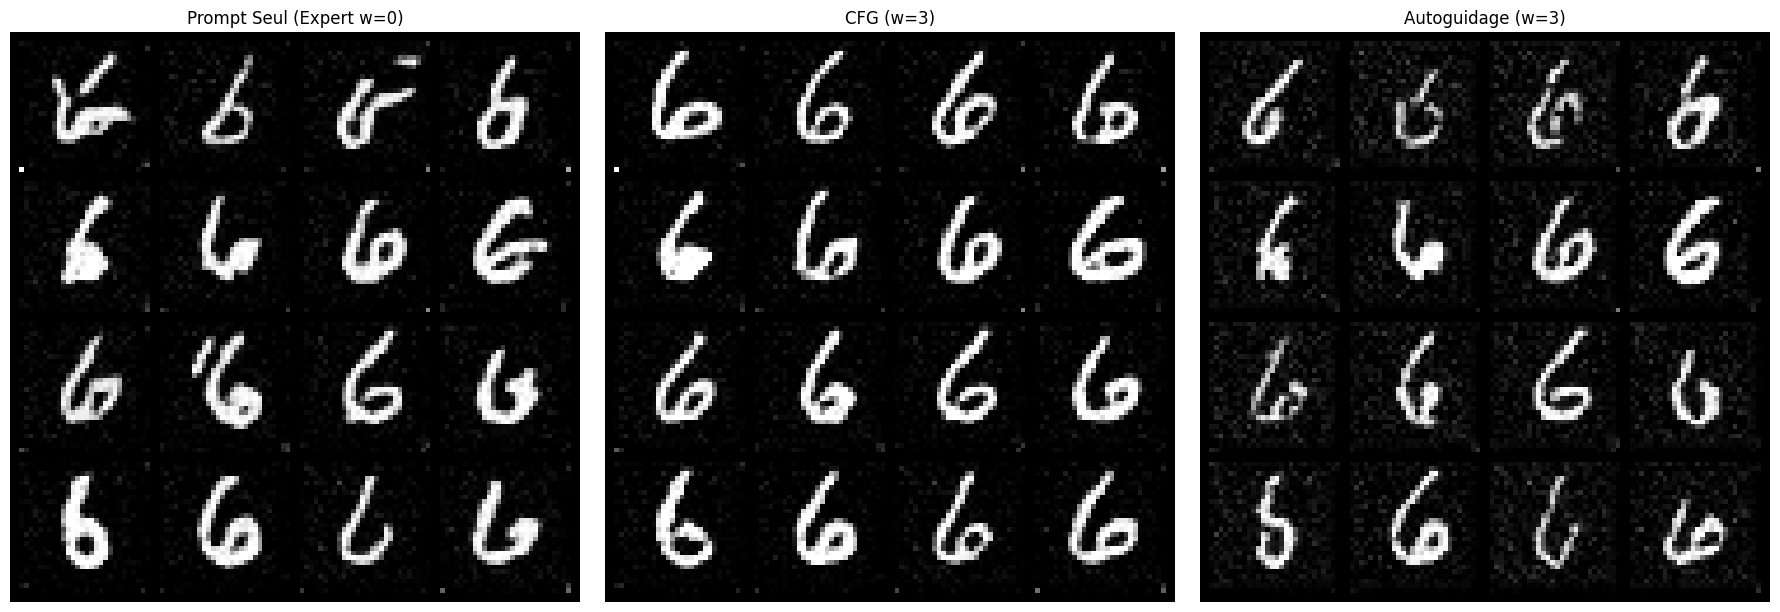

In [30]:
# Paramètres communs
prompt_test = 6
w_val = 3  # Note: à 1.0 l'effet est subtil, essaie 3.0 ou 5.0 pour bien voir la différence
torch.manual_seed(42)

# 1. Prompt Seul (Expert pur, w=0)
# On utilise le sampler autoguidage avec w=1 pour avoir le score de l'expert pur
samples_pure = Autoguidance_Euler_Maruyama_sampler(expert, amateur, marginal_prob_std_fn, diffusion_coeff_fn,
                                                  prompt_label=prompt_test, w=1.0, batch_size=16)

# 2. Génération CFG (Expert uniquement, avec soustraction inconditionnelle)
torch.manual_seed(42)
samples_cfg = CFG_Euler_Maruyama_sampler(expert, marginal_prob_std_fn, diffusion_coeff_fn,
                                        prompt_label=prompt_test, w=w_val, batch_size=16)

# 3. Génération Autoguidage (Expert + Amateur)
torch.manual_seed(42)
samples_auto = Autoguidance_Euler_Maruyama_sampler(expert, amateur, marginal_prob_std_fn, diffusion_coeff_fn,
                                                  prompt_label=prompt_test, w=w_val, batch_size=16)

# Visualisation comparative
def plot_res(imgs, title):
    grid = make_grid(imgs.clamp(0,1), nrow=4)
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1); plot_res(samples_pure, "Prompt Seul (Expert w=0)")
plt.subplot(1, 3, 2); plot_res(samples_cfg, f"CFG (w={w_val})")
plt.subplot(1, 3, 3); plot_res(samples_auto, f"Autoguidage (w={w_val})")
plt.tight_layout()
plt.show()